# Face Recognition 

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier

## Load Folder

In [2]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }

dataset = load_images('./Data/')

In [3]:
print("Shape of images:", dataset['data'].shape)
print("Shape of labels:", dataset['target'].shape)
print("Unique labels:", dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


## Data Visualization

### Image Distribuition of Top 20 People

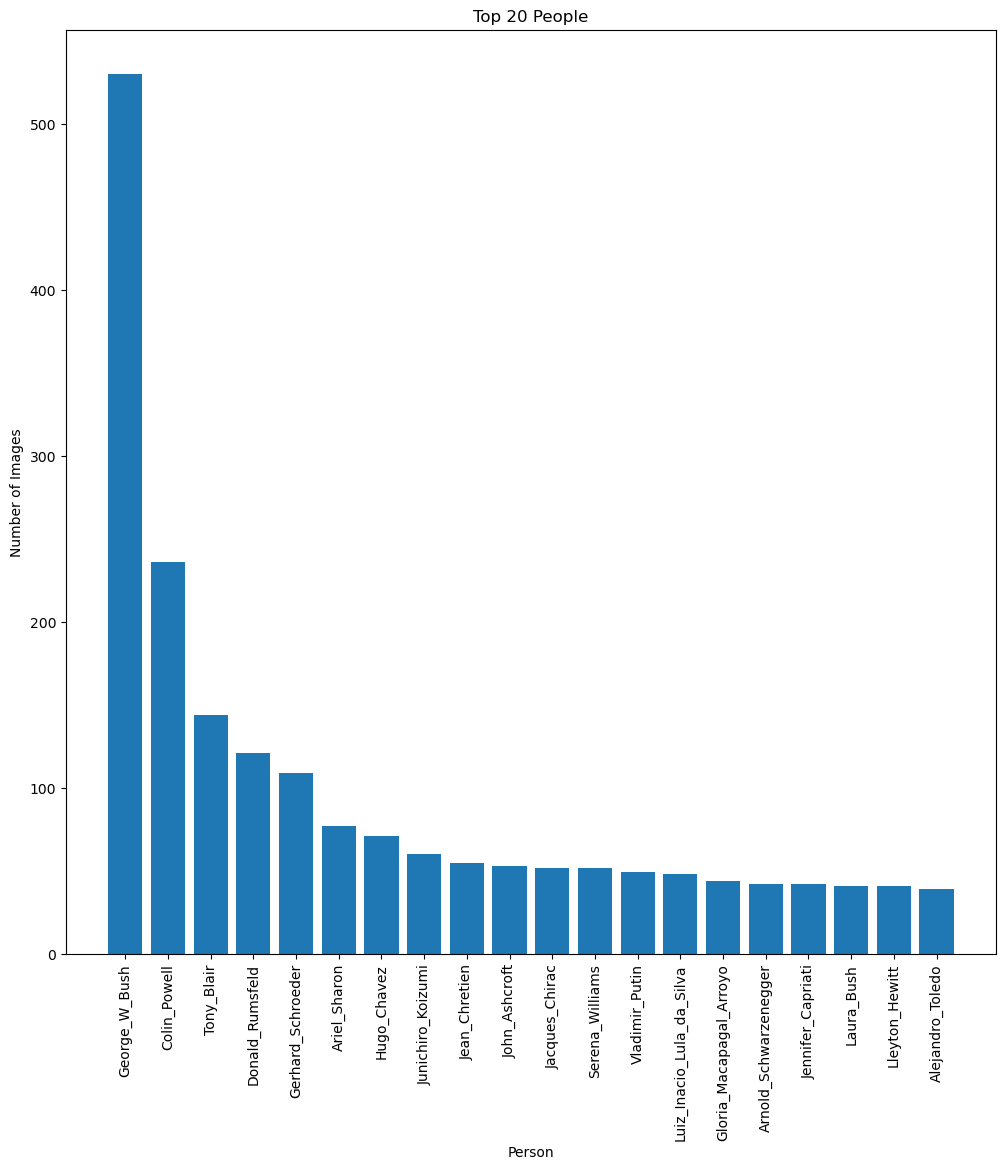

In [4]:
target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [5]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-20', '21-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

,# of images /person,# of people,% of people,# of images,% of images
0,1,4069,70.78,4069,30.75
1,2-5,1369,23.81,3739,28.26
2,6-10,168,2.92,1251,9.45
3,11-20,86,1.50,1251,9.45
4,21-30,25,0.43,613,4.63
5,31-80,27,0.47,1170,8.84
6,>81,5,0.09,1140,8.61


### Plot Some Images

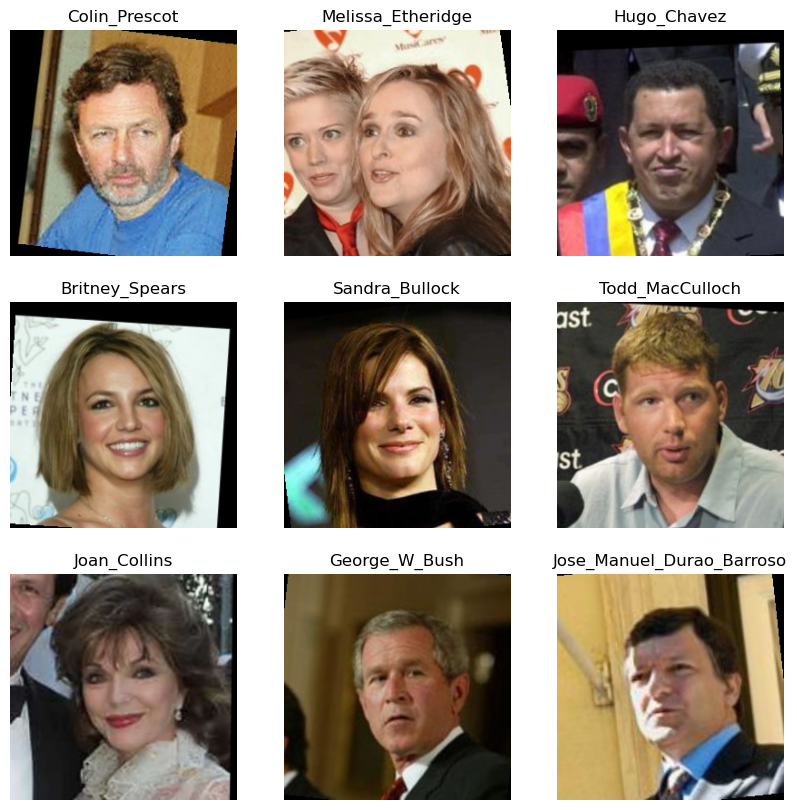

In [6]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## Data Preprocessing

### Image Resizing

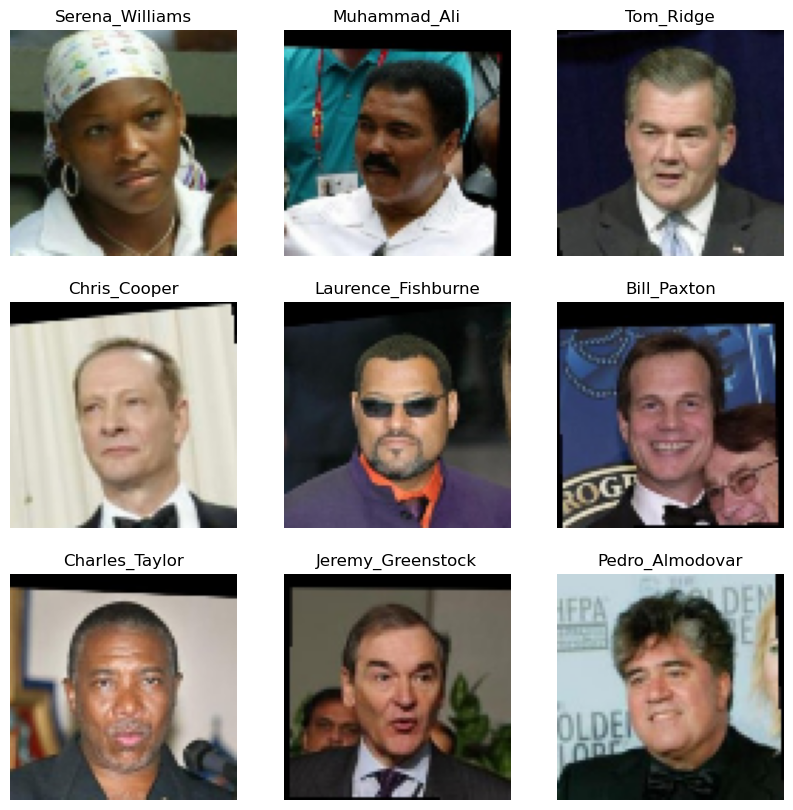

In [7]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(80, 80))


display_random_images(resized_images, dataset['target'], 3, 3)

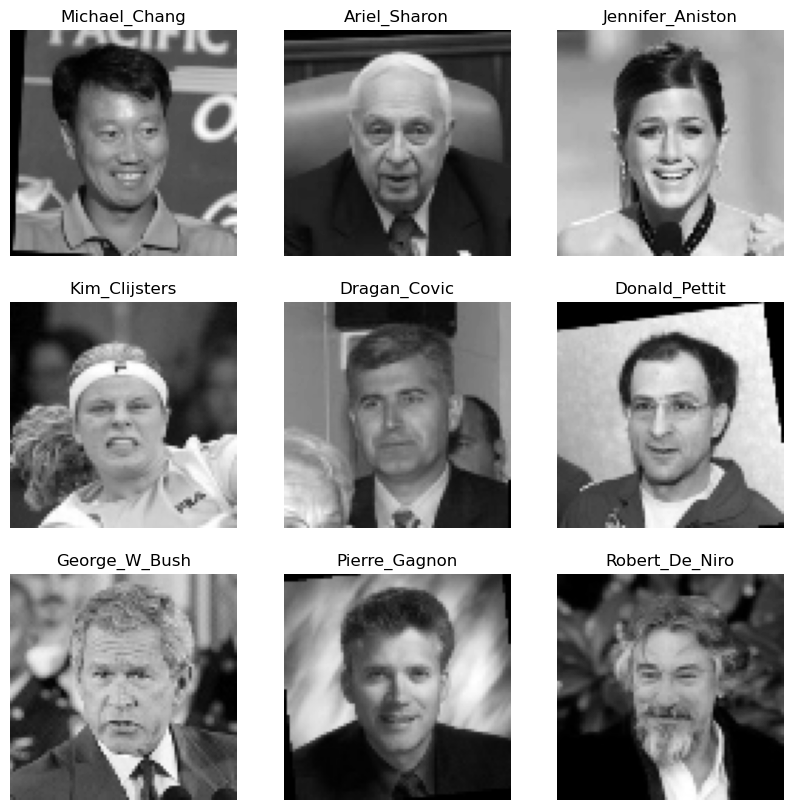

In [8]:
# Gray scale
def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

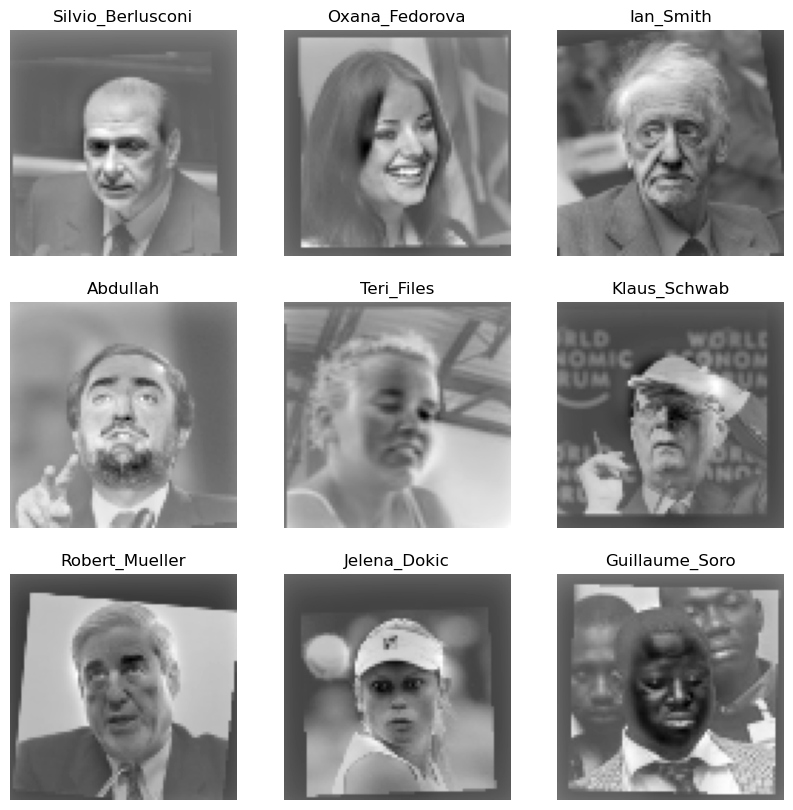

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_images = scaler.fit_transform(gray_images.reshape(-1, 80 * 80)).reshape(-1, 80, 80)


display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

### Feature Extractions

In [10]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images

filtered_dataset = filter_dataset(dataset, min_faces_per_person=30)

In [11]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape


print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (2370, 80, 80)


#### TRAIN-TEST-SPLIT

In [12]:
X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1896, 6400)
Shape of X_test: (474, 6400)
Shape of y_train: (1896,)
Shape of y_test: (474,)


#### PCA

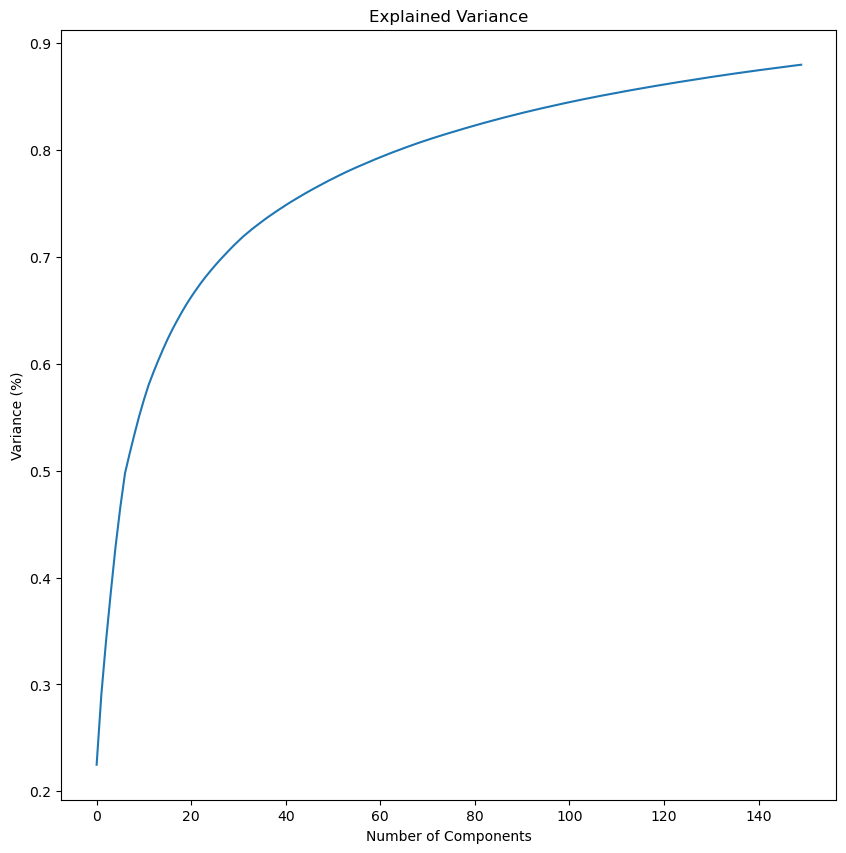

In [16]:
def pca_transform(X_train, X_test, n_components=None):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


X_train_pca, X_test_pca, pca = pca_transform(X_train, X_test, n_components=150)

# Function to plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

#### LDA

In [15]:
def lda_transform(X_train, y_train, X_test, n_components=None):
    lda = LDA(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_test_lda

X_train_lda, X_test_lda = lda_transform(X_train, y_train, X_test)

## Model Training

In [46]:
# Accuracy List
models_accuracy = {}

# Define the models
svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001, random_state=42, class_weight='balanced')
lda_clf = LDA()
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=20, bootstrap=False, random_state=42, class_weight='balanced')

# Define feature extraction methods
feature_extraction_methods = {'PCA', 'LDA'}

# Loop through models
for model, model_name in zip([svm_clf, lda_clf, rf_clf], ['SVM', 'LDA', 'RF']):
    # Loop through feature extraction methods
    for method in feature_extraction_methods:
        # Choose feature extraction method
        if method == 'PCA':
            X_train_transformed = X_train_pca
            X_test_transformed = X_test_pca
        elif method == 'LDA':
            X_train_transformed = X_train_lda
            X_test_transformed = X_test_lda

        # Train the model
        model.fit(X_train_transformed, y_train)

        # Make predictions
        y_pred = model.predict(X_test_transformed)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)

        # Save results
        models_accuracy[f'{model_name}_{method}'] = accuracy

        # Print results
        print(f'{model_name} with {method} - Accuracy:', accuracy)

# Display the overall accuracy results
print("Overall Accuracy Results:")
print(models_accuracy)

SVM with PCA - Accuracy: 0.6645569620253164
SVM with LDA - Accuracy: 0.5780590717299579
LDA with PCA - Accuracy: 0.7194092827004219
LDA with LDA - Accuracy: 0.5864978902953587
RF with PCA - Accuracy: 0.42616033755274263
RF with LDA - Accuracy: 0.48945147679324896
Overall Accuracy Results:
{'SVM_PCA': 0.6645569620253164, 'SVM_LDA': 0.5780590717299579, 'LDA_PCA': 0.7194092827004219, 'LDA_LDA': 0.5864978902953587, 'RF_PCA': 0.42616033755274263, 'RF_LDA': 0.48945147679324896}


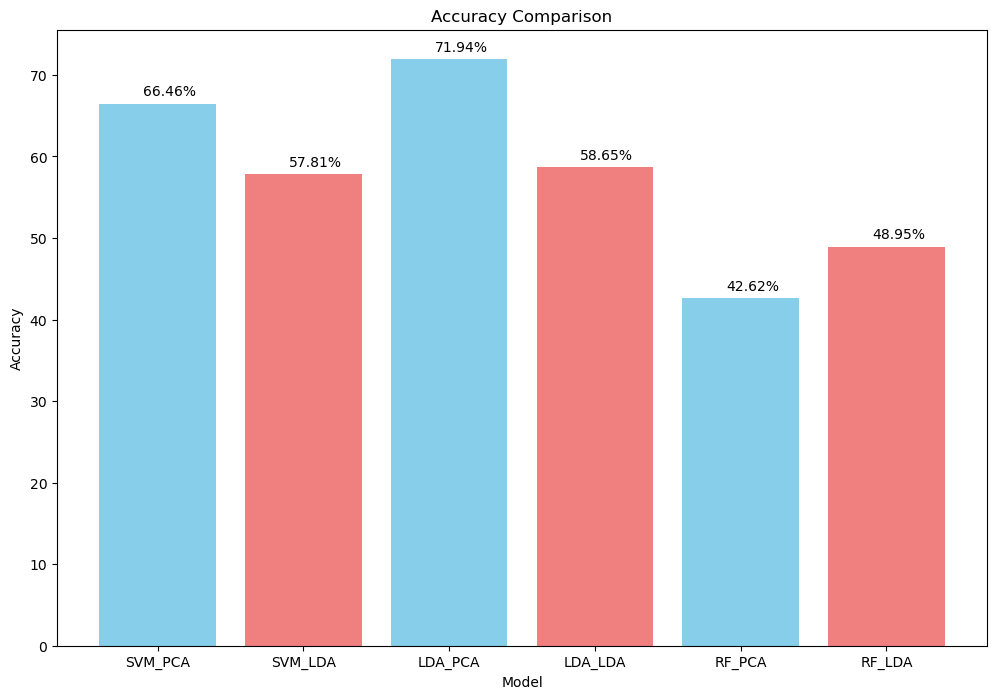

In [57]:
# Function to plot accuracy results

# Colors RED FOR PCA, BLUE FOR LDA

colors = [
    "skyblue" if "PCA" in model_name else "lightcoral"
    for model_name in models_accuracy.keys()
]

# CHANGE ACCURACY TO % AND Plot
models_accuracy_percentage = {k: v * 100 for k, v in models_accuracy.items()}

plt.figure(figsize=(12, 8))
plt.bar(models_accuracy.keys(), models_accuracy_percentage.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')

for i, v in enumerate(models_accuracy_percentage.values()):
    plt.text(i - 0.1, v + 1, str(round(v, 2)) + '%')

plt.title('Accuracy Comparison')
plt.show()